---
title: "추천 시스템 스터디 실습 예제 3"
author: "Sangkon Han"
---

## 인기 영화 추천 시스템을 만들어 보자

- 이 [데이터셋](https://www.kaggle.com/tmdb/tmdb-movie-metadata)은 영화에 대한 정보(예산, 장르, 평점, 런닝시간, 제목, 키워드 등등)와 영화 연출팀과 배우들에 대한 별도 정보로 구성되어 있으며 일반 사용자들이 이 정보를 입력하여 구성
- 이를 바탕으로 인기 영화 추천을 간단하게 작성
    - 넷플릭스를 보면 "넷플릭스 인기 콘텐츠"라는 추천 카테고리가 있는데 같은 거라 보면 된다
- 장르를 기준으로 그 안에서 인기영화를 추천

### 입력 데이터 로딩

- 영화 정보는 `tmdb_5000_movies.csv`
- 연출/배우에 대한 정보는 `tmdb_5000_credits.csv`

이 두 파일은 영화의 id 필드와 연출/배우의 movie_id 필드로 조인 가능하다.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# movies = pd.read_csv(
#     "https://grepp-reco-test.s3.ap-northeast-2.amazonaws.com/tmdb_5000_movies.csv"
# )
# credits = pd.read_csv(
#     "https://grepp-reco-test.s3.ap-northeast-2.amazonaws.com/tmdb_5000_credits.csv"
# )

In [3]:
movies = pd.read_csv("data/tmdb_5000_movies.csv")
credits = pd.read_csv("data/tmdb_5000_credits.csv")

In [4]:
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [5]:
movies.shape

(4803, 20)

In [6]:
import json



def add_genre_name(j):


    genres = []

    ar = json.loads(j)

    for a in ar:
        genres.append(a.get("name"))


    return " ".join(sorted(genres))



movies["genres_name"] = movies.apply(lambda x: add_genre_name(x.genres), axis=1)

In [7]:
movies[["genres_name"]].head()  # vs. movies['genres_name'].head()

,genres_name
0,Action Adventure Fantasy Science Fiction
1,Action Adventure Fantasy
2,Action Adventure Crime
3,Action Crime Drama Thriller
4,Action Adventure Science Fiction


In [8]:
movies["genres_name"].nunique()

638

In [9]:
movies.groupby("genres_name").size()

genres_name
                                            28
Action                                      21
Action Adventure                            15
Action Adventure Animation                   1
Action Adventure Animation Comedy Family     5
                                            ..
Science Fiction Thriller                    12
Thriller                                    23
War                                          2
War Western                                  1
Western                                     18
Length: 638, dtype: int64

In [10]:
credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [11]:
credits.shape

(4803, 4)

### movies와 credits 데이터프레임을 조인

In [12]:
movie_credits = pd.merge(movies, credits, left_on="id", right_on="movie_id")

In [13]:
movie_credits.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,status,tagline,title_x,vote_average,vote_count,genres_name,movie_id,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,Released,Enter the World of Pandora.,Avatar,7.2,11800,Action Adventure Fantasy Science Fiction,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Action Adventure Fantasy,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,Released,A Plan No One Escapes,Spectre,6.3,4466,Action Adventure Crime,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Action Crime Drama Thriller,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,Released,"Lost in our world, found in another.",John Carter,6.1,2124,Action Adventure Science Fiction,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [14]:
movie_credits = movie_credits.drop(
    columns=[
        "homepage",
        "title_x",
        "title_y",
        "status",
        "production_countries",
        "production_companies",
    ]
)


movie_credits.head()

,budget,genres,id,keywords,original_language,original_title,overview,popularity,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,genres_name,movie_id,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Enter the World of Pandora.,7.2,11800,Action Adventure Fantasy Science Fiction,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]","At the end of the world, the adventure begins.",6.9,4500,Action Adventure Fantasy,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",A Plan No One Escapes,6.3,4466,Action Adventure Crime,206647,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",The Legend Ends,7.6,9106,Action Crime Drama Thriller,49026,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]","Lost in our world, found in another.",6.1,2124,Action Adventure Science Fiction,49529,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [15]:
movie_credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   budget             4803 non-null   int64  
 1   genres             4803 non-null   object 
 2   id                 4803 non-null   int64  
 3   keywords           4803 non-null   object 
 4   original_language  4803 non-null   object 
 5   original_title     4803 non-null   object 
 6   overview           4800 non-null   object 
 7   popularity         4803 non-null   float64
 8   release_date       4802 non-null   object 
 9   revenue            4803 non-null   int64  
 10  runtime            4801 non-null   float64
 11  spoken_languages   4803 non-null   object 
 12  tagline            3959 non-null   object 
 13  vote_average       4803 non-null   float64
 14  vote_count         4803 non-null   int64  
 15  genres_name        4803 non-null   object 
 16  movie_id           4803 

In [16]:
movie_credits.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count,movie_id
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989,57165.484281
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891,88694.614033
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,5.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000,9014.500000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000,14629.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000,58610.500000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000,459488.000000


In [17]:
popularity = movie_credits.sort_values("popularity", ascending=False)

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0, 0.5, 'Movie Title')

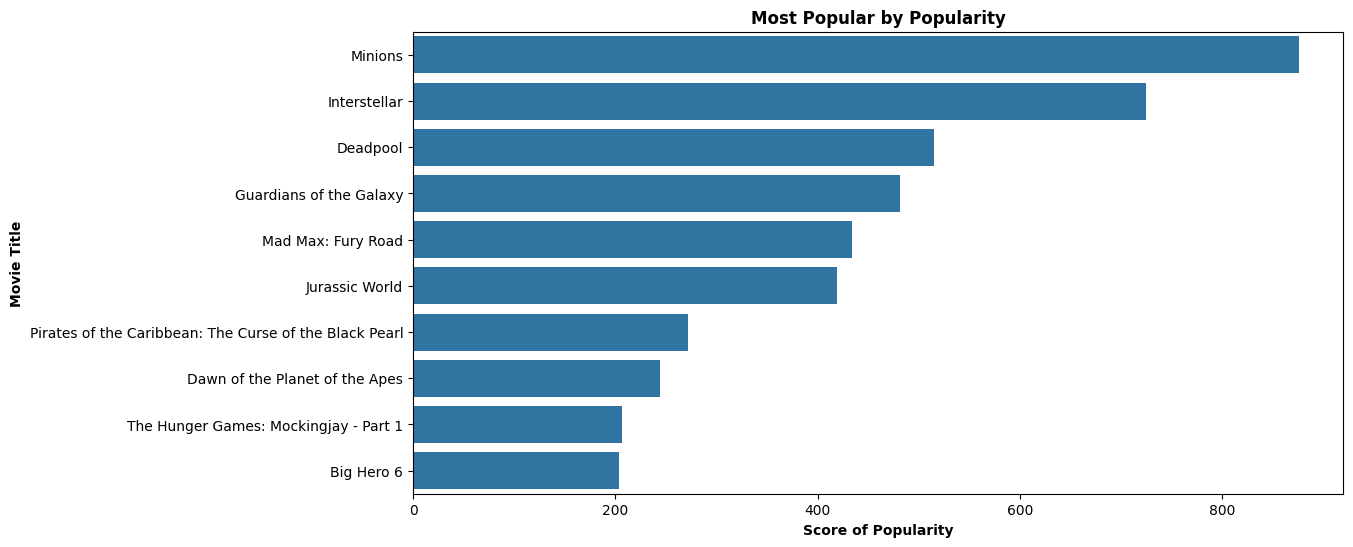

In [19]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x=popularity["popularity"].head(10), y=popularity["original_title"].head(10)
)
plt.title("Most Popular by Popularity", weight="bold")
plt.xlabel("Score of Popularity", weight="bold")
plt.ylabel("Movie Title", weight="bold")

### Top-K 함수 작성

In [20]:
def reco_top_scored_one(n, genre=None):
    if genre is None:
        return popularity["original_title"].head(n)
    else:
        return popularity[popularity["genres_name"].str.contains(genre)][
            "original_title"
        ].head(n)

In [21]:
print(reco_top_scored_one(10))

546                                              Minions
95                                          Interstellar
788                                             Deadpool
94                               Guardians of the Galaxy
127                                   Mad Max: Fury Road
28                                        Jurassic World
199    Pirates of the Caribbean: The Curse of the Bla...
82                        Dawn of the Planet of the Apes
200                The Hunger Games: Mockingjay - Part 1
88                                            Big Hero 6
Name: original_title, dtype: object


In [22]:
print(reco_top_scored_one(10, "Science Fiction"))

95                              Interstellar
94                   Guardians of the Galaxy
127                       Mad Max: Fury Road
28                            Jurassic World
82            Dawn of the Planet of the Apes
200    The Hunger Games: Mockingjay - Part 1
108                       Terminator Genisys
26                Captain America: Civil War
270                              The Martian
96                                 Inception
Name: original_title, dtype: object


In [23]:
print(reco_top_scored_one(10, "Action"))

788                                             Deadpool
94                               Guardians of the Galaxy
127                                   Mad Max: Fury Road
28                                        Jurassic World
199    Pirates of the Caribbean: The Curse of the Bla...
82                        Dawn of the Planet of the Apes
88                                            Big Hero 6
108                                   Terminator Genisys
26                            Captain America: Civil War
65                                       The Dark Knight
Name: original_title, dtype: object


## 유사도 계산(텍스트)

### 카운트 기반

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pandas as pd

In [25]:
text = [
    "The see is blue.",  # ‘sky’, ‘blue’
    "The sky is bright.",  # ‘sun’, ‘bright’
    "The sky in the sea is bright",  # ‘sun’, ‘sky’, ‘bright’
    "We can see the shining see, the bright sky .",  # ‘ see’, ‘shining’, ‘sun’, ‘bright’
]

In [26]:
countvectorizer = CountVectorizer(analyzer="word", stop_words="english")

In [27]:
count_wm = countvectorizer.fit_transform(text)
print(count_wm.shape)
print(count_wm.todense())

(4, 5)
[[1 0 0 0 0]
 [0 1 0 0 1]
 [0 1 1 0 1]
 [0 1 0 1 1]]


In [28]:
count_tokens = countvectorizer.get_feature_names_out()
print(count_tokens)
df_countvect = pd.DataFrame(
    data=count_wm.toarray(),
    index=["S1", "S2", "S3", "S4"],
    columns=count_tokens,
)
df_countvect.head()

['blue' 'bright' 'sea' 'shining' 'sky']


,blue,bright,sea,shining,sky
S1,1,0,0,0,0
S2,0,1,0,0,1
S3,0,1,1,0,1
S4,0,1,0,1,1


In [29]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarities = cosine_similarity(count_wm)
print(cosine_similarities)

[[1.         0.         0.         0.        ]
 [0.         1.         0.81649658 0.81649658]
 [0.         0.81649658 1.         0.66666667]
 [0.         0.81649658 0.66666667 1.        ]]


In [30]:
pd.DataFrame(
    data=cosine_similarities,
    index=["S1", "S2", "S3", "S4"],
    columns=["S1", "S2", "S3", "S4"],
)

,S1,S2,S3,S4
S1,1.0,0.000000,0.000000,0.000000
S2,0.0,1.000000,0.816497,0.816497
S3,0.0,0.816497,1.000000,0.666667
S4,0.0,0.816497,0.666667,1.000000


### TF-IDF 기반

$TF-IDF$ = $TF(t, d) \times IDF(t)$

* $TF(t, d)$: 단어 $t$가 문서 $d$에서 몇번 나왔나?
* $IDF(t)$: 단어가 $t$가 전체 문서들 중 몇개의 문서에서 나왔는지? $Ln(N/DF)$
    * $N$은 총 문서수를 나타내고 $D$F는 단어가 나온 문서
    
기본적인 아이디어는 전체 문서에서 빈도수가 낮은 단어가 특정 문서에서 많이 나오는 경우 해당 문서에서 해당 단어의 점수가 더 높게 계산됨

In [31]:
tfidfvectorizer = TfidfVectorizer(analyzer="word", stop_words="english")

In [32]:
tfidf_wm = tfidfvectorizer.fit_transform(text)
print(tfidf_wm.shape)
print(tfidf_wm.todense())

(4, 5)
[[1.         0.         0.         0.         0.        ]
 [0.         0.70710678 0.         0.         0.70710678]
 [0.         0.47380449 0.74230628 0.         0.47380449]
 [0.         0.47380449 0.         0.74230628 0.47380449]]


In [33]:
tfidf_tokens = tfidfvectorizer.get_feature_names_out()
print(tfidf_tokens)
df_tfidfvect = pd.DataFrame(
    data=tfidf_wm.toarray(),
    index=["S1", "S2", "S3", "S4"],
    columns=tfidf_tokens,
)
df_tfidfvect.head()

['blue' 'bright' 'sea' 'shining' 'sky']


,blue,bright,sea,shining,sky
S1,1.0,0.000000,0.000000,0.000000,0.000000
S2,0.0,0.707107,0.000000,0.000000,0.707107
S3,0.0,0.473804,0.742306,0.000000,0.473804
S4,0.0,0.473804,0.000000,0.742306,0.473804


## 내용 기반 추천시스템

*   영화 정보는 tmdb_5000_movies.csv라는 파일에 있다. 이 파일만 사용할 예정


In [34]:
import pandas as pd
import numpy as np

In [35]:
movies = pd.read_csv("data/tmdb_5000_movies.csv")

In [36]:
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [37]:
movies.shape

(4803, 20)

In [38]:
# 샘플 DataFrame 생성
df_example = pd.DataFrame(
    {"Math": [82, 90, 76], "Science": [88, 92, 94], "English": [78, 85, 88]}
)

In [39]:
df_example.head()

,Math,Science,English
0,82,88,78
1,90,92,85
2,76,94,88


In [40]:
# 각 열의 최대값 찾기
max_values_per_column = df_example.apply(max, axis=0)

# 각 행의 평균 계산하기
average_values_per_row = df_example.apply(lambda row: row.mean(), axis=1)

print(max_values_per_column, average_values_per_row)

Math       90
Science    94
English    88
dtype: int64 0    82.666667
1    89.000000
2    86.000000
dtype: float64


In [41]:
import json


def f(j):
    genres = []
    ar = json.loads(j)
    for a in ar:
        genres.append(a.get("name"))
    return " ".join(sorted(genres))


# apply 함수를 사용할 때 axis를 1로 주어야 한 레코드내의 필드들을 액세스 가능
#                               0으로 주면
movies["genres_name"] = movies.apply(lambda x: f(x.genres), axis=1)

In [42]:
movies[["genres_name"]].head()  # vs. movies['genres_name'].head()

,genres_name
0,Action Adventure Fantasy Science Fiction
1,Action Adventure Fantasy
2,Action Adventure Crime
3,Action Crime Drama Thriller
4,Action Adventure Science Fiction


In [43]:
movies["genres_name"].nunique()

638

In [44]:
movies.groupby("genres_name").size()

genres_name
                                            28
Action                                      21
Action Adventure                            15
Action Adventure Animation                   1
Action Adventure Animation Comedy Family     5
                                            ..
Science Fiction Thriller                    12
Thriller                                    23
War                                          2
War Western                                  1
Western                                     18
Length: 638, dtype: int64

### 여러 텍스트 필드들을 모아서 텍스트 유사도에 사용할 텍스트 필드 하나를 생성

In [45]:
for f in ["original_title", "overview", "genres_name"]:
    movies[f] = movies[f].fillna("")

In [46]:
def combine_features(row):
    try:
        return row["original_title"] + " " + row["overview"] + " " + row["genres_name"]
    except:
        print("Error:", row)

In [47]:
movies["combined_features"] = movies.apply(combine_features, axis=1)

In [48]:
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,genres_name,combined_features
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Action Adventure Fantasy Science Fiction,"Avatar In the 22nd century, a paraplegic Marin..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Action Adventure Fantasy,Pirates of the Caribbean: At World's End Capta...
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Action Adventure Crime,Spectre A cryptic message from Bond’s past sen...
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Action Crime Drama Thriller,The Dark Knight Rises Following the death of D...
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Action Adventure Science Fiction,"John Carter John Carter is a war-weary, former..."


In [49]:
movies = movies.reset_index()  # index라는 필드를 만들어줌
movies.head()

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,genres_name,combined_features
0,0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Action Adventure Fantasy Science Fiction,"Avatar In the 22nd century, a paraplegic Marin..."
1,1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Action Adventure Fantasy,Pirates of the Caribbean: At World's End Capta...
2,2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Action Adventure Crime,Spectre A cryptic message from Bond’s past sen...
3,3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Action Crime Drama Thriller,The Dark Knight Rises Following the death of D...
4,4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Action Adventure Science Fiction,"John Carter John Carter is a war-weary, former..."


In [50]:
movies["combined_features"].head()

0    Avatar In the 22nd century, a paraplegic Marin...
1    Pirates of the Caribbean: At World's End Capta...
2    Spectre A cryptic message from Bond’s past sen...
3    The Dark Knight Rises Following the death of D...
4    John Carter John Carter is a war-weary, former...
Name: combined_features, dtype: object

### TF-IDF 기반 벡터 생성 후 코사인 유사도로 영화들간의 유사도 계산

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [52]:
tfidfvectorizer = TfidfVectorizer(analyzer="word", stop_words="english", norm="l2")

In [53]:
tfidf_matrix = tfidfvectorizer.fit_transform(movies["combined_features"])

In [54]:
tfidf_matrix.shape  #  min_df 파라미터!!!

(4803, 22179)

In [55]:
cosine_sim = cosine_similarity(
    tfidf_matrix
)  # linear_kernel을 사용해도 동일함. tfidf 벡터가 생성될 때 L2 normalization이 되었기 때문

In [56]:
df_cosine_sim = pd.DataFrame(data=cosine_sim)
df_cosine_sim.head()

,0,1,2,3,4,5,6,7,8,9,...,4793,4794,4795,4796,4797,4798,4799,4800,4801,4802
0,1.000000,0.034109,0.013909,0.026299,0.029273,0.046984,0.003855,0.068451,0.020614,0.020293,...,0.000000,0.000000,0.026697,0.057602,0.000000,0.003941,0.0,0.000000,0.000000,0.000000
1,0.034109,1.000000,0.014576,0.004304,0.047903,0.023093,0.004040,0.039814,0.021603,0.029597,...,0.016368,0.044292,0.006000,0.000000,0.000000,0.004130,0.0,0.022717,0.016449,0.000000
2,0.013909,0.014576,1.000000,0.008018,0.009303,0.009417,0.003084,0.041851,0.023712,0.008672,...,0.022647,0.000000,0.000000,0.000000,0.015928,0.007694,0.0,0.011636,0.000000,0.000000
3,0.026299,0.004304,0.008018,1.000000,0.011748,0.007161,0.014069,0.027766,0.028148,0.158541,...,0.002655,0.003020,0.001183,0.004516,0.001678,0.007343,0.0,0.029067,0.038273,0.019549
4,0.029273,0.047903,0.009303,0.011748,1.000000,0.007872,0.011027,0.054503,0.005454,0.019947,...,0.010447,0.000000,0.000000,0.013190,0.000000,0.002636,0.0,0.004744,0.000000,0.000000


### 내용 기반 추천 함수 만들기

In [57]:
def get_title_from_index(df, index):
    return df[df.index == index]["original_title"].values[0]


def get_index_from_title(df, title):
    return df[df.original_title == title]["index"].values[0]

In [58]:
cosine_sim[0]

array([1.        , 0.03410854, 0.01390903, ..., 0.        , 0.        ,
       0.        ])

In [59]:
for cs in enumerate(cosine_sim[0]):
    print(cs)

(0, np.float64(1.0))
(1, np.float64(0.03410853782660228))
(2, np.float64(0.013909027833476929))
(3, np.float64(0.026299406427582793))
(4, np.float64(0.029272658943387594))
(5, np.float64(0.04698429164961723))
(6, np.float64(0.0038547145246063327))
(7, np.float64(0.06845111489143473))
(8, np.float64(0.020614257715725205))
(9, np.float64(0.020292514366589152))
(10, np.float64(0.04234078479474402))
(11, np.float64(0.027006676853799445))
(12, np.float64(0.03161857450875023))
(13, np.float64(0.01012938358302969))
(14, np.float64(0.06041309047742963))
(15, np.float64(0.013328113123785307))
(16, np.float64(0.036370965857215116))
(17, np.float64(0.028506554034230434))
(18, np.float64(0.02162195731499623))
(19, np.float64(0.01754390776383305))
(20, np.float64(0.015890840282328227))
(21, np.float64(0.013010542711000998))
(22, np.float64(0.01988359152099039))
(23, np.float64(0.02889593817447863))
(24, np.float64(0.01455452908886643))
(25, np.float64(0.0))
(26, np.float64(0.06238914032771081))
(27

In [60]:
def reco_top_similar_movies(movie_title, n=10):
    movie_index = get_index_from_title(movies, movie_title)
    similar_movies = enumerate(cosine_sim[movie_index])
    sorted_similar_movies = sorted(similar_movies, key=lambda x: x[1], reverse=True)

    ret_movies = []
    i = 0
    for element in sorted_similar_movies:
        title = get_title_from_index(movies, element[0])
        ret_movies.append(title)
        i = i + 1
        if i >= n:
            break
    return ret_movies

In [61]:
print(reco_top_similar_movies("Avatar", 5))

['Avatar', 'Apollo 18', 'The American', 'Obitaemyy Ostrov', 'The Matrix']


In [62]:
print(reco_top_similar_movies("Minions", 5))

['Minions', 'Despicable Me 2', 'Stuart Little 2', 'Stuart Little', 'Austin Powers: The Spy Who Shagged Me']


In [63]:
print(reco_top_similar_movies("Harry Potter and the Half-Blood Prince", 5))

['Harry Potter and the Half-Blood Prince', 'Harry Potter and the Goblet of Fire', 'Harry Potter and the Order of the Phoenix', 'Harry Potter and the Chamber of Secrets', 'Harry Potter and the Prisoner of Azkaban']
